# Using HoloPy

[Read the docs.](https://holopy.readthedocs.io/en/master/tutorial/index.html)

## Tutorial for reconstruction (collimated illumination)

C:\Users\j05625pe\Anaconda3\envs\gentl_37\lib\site-packages\holopy\core\io\vis.py:264: UserWarning: Image contains complex values. Taking image magnitude.
  warn("Image contains complex values. Taking image magnitude.")


<IPython.core.display.Javascript object>


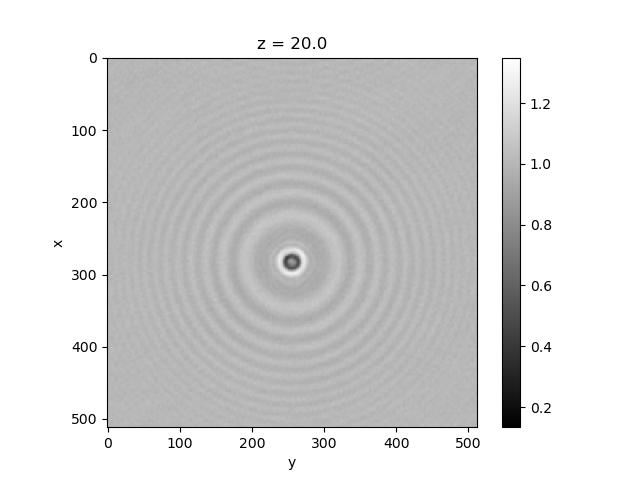

In [9]:
import holopy as hp
import numpy as np
%matplotlib notebook

from holopy.core.io import get_example_data_path
from holopy.core.process import bg_correct

imagepath = get_example_data_path('image01.jpg')
raw_holo = hp.load_image(imagepath, spacing = 0.0851)
# hp.show(raw_holo)

# Single background correction
bgpath = get_example_data_path('bg01.jpg')
bg = hp.load_image(bgpath, spacing = 0.0851)
holo = bg_correct(raw_holo, bg)
# hp.show(holo)

# Multiple background correction
bgpath = get_example_data_path(['bg01.jpg', 'bg02.jpg', 'bg03.jpg'])
bg = hp.core.io.load_average(bgpath, refimg = raw_holo)
holo = bg_correct(raw_holo, bg)
# hp.show(holo)

# Removing stray light
dfpath = get_example_data_path('df01.jpg')
df = hp.load_image(dfpath, spacing = 0.0851)
holo = bg_correct(raw_holo, bg, df)
# hp.show(holo)

# Adding info about the setup
holo = hp.core.update_metadata(holo, medium_index=1.33, illum_wavelen=0.660, illum_polarization=(1,0))
# Save data (HDF5 compression). Load with hp.load()
# hp.save('Holopy\outfilename', holo)

# Propagation
zstack = np.linspace(0, 20, 11)  # The units are given by the metadata, in this case, um.
rec_vol = hp.propagate(holo, zstack, cfsp = 3)  # cfsp is for cascaded free space propagation
hp.show(rec_vol)

## Tutorial for scattering calculations

<IPython.core.display.Javascript object>


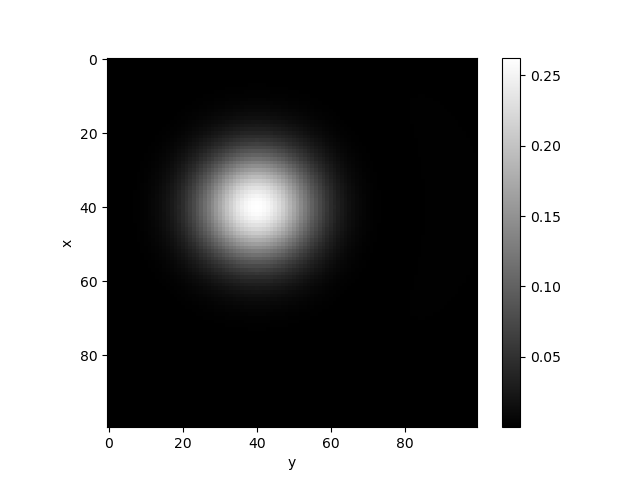

In [13]:
import holopy as hp
from holopy.scattering import calc_holo, Sphere
from holopy.core.io import get_example_data_path

# Define a scatterer
sphere = Sphere(n=1.59, r=0.5, center=(4, 4, 5))
# Define the setup
medium_index = 1.33
illum_wavelen = 0.660
illum_polarization = (1, 0)
detector = hp.detector_grid(shape=100, spacing=0.1)
# Calculate the hologram
holo = calc_holo(detector, sphere, medium_index, illum_wavelen,
                 illum_polarization, theory='auto')
# hp.show(holo)

# Using an image to define the setup.
imagepath = get_example_data_path('image0002.h5')
exp_img = hp.load(imagepath)
holo = calc_holo(exp_img, sphere)
# hp.show(holo)

# Calculate the field or the intensity
field = hp.scattering.calc_field(exp_img, sphere)
intensity = hp.scattering.calc_intensity(exp_img, sphere)
hp.show(intensity)

## Tutorial for fitting model to data

<IPython.core.display.Javascript object>


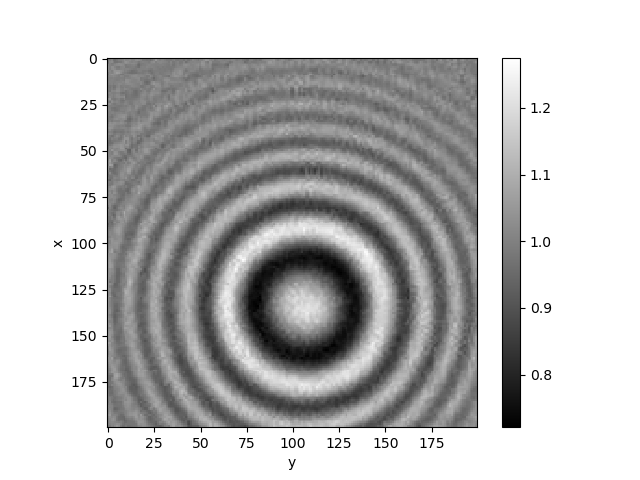

<IPython.core.display.Javascript object>


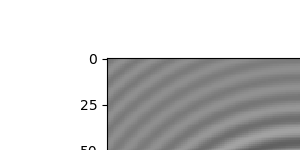

Best fit values: {'r': 0.556409160591163, 'x': 24.170346855286446, 'y': 21.842512274997116, 'z': 16.632596474053024, 'alpha': 0.7075242182447431}
Best fit sphere: Sphere(n=1.58, r=0.556409160591163, center=[24.170346855286446, 21.842512274997116, 16.632596474053024])
Best fit lnprob: -4036771.185093507
Time of fitting: 37.7 s.


In [21]:
import holopy as hp
import numpy as np
from holopy.core.io import get_example_data_path, load_average
from holopy.core.process import bg_correct, subimage, normalize
from holopy.scattering import Sphere, Spheres, calc_holo
from holopy.inference import prior, ExactModel, CmaStrategy, EmceeStrategy
import time

# load an image
imagepath = get_example_data_path('image01.jpg')
raw_holo = hp.load_image(imagepath, spacing = 0.0851, medium_index = 1.33,
                         illum_wavelen = 0.66, illum_polarization = (1,0))
bgpath = get_example_data_path(['bg01.jpg','bg02.jpg','bg03.jpg'])
bg = load_average(bgpath, refimg = raw_holo)
data_holo = bg_correct(raw_holo, bg)

# process the image
data_holo = subimage(data_holo, [250,250], 200)  # center point and xy span
data_holo = normalize(data_holo)
# hp.show(data_holo)

# Estimate center and z position using propagation
guess_sphere = Sphere(n=1.58, r=0.5, center=[24,22,15])
initial_guess = calc_holo(data_holo, guess_sphere)
hp.show(data_holo)
# hp.show(initial_guess)

# Do the fitting
parameters_to_fit = ['x', 'y', 'z', 'r'] # We are not fitting the index refraction
t1 = time.perf_counter()
fit_result = hp.fit(data_holo, guess_sphere, parameters=parameters_to_fit)
fit_time = time.perf_counter() - t1

# Reading the result
best_fit_values = fit_result.parameters
initial_guess_values = fit_result.guess_parameters
best_fit_sphere = fit_result.scatterer
best_fit_hologram = fit_result.hologram
best_fit_lnprob = fit_result.max_lnprob
hp.show(best_fit_hologram)
print(f'Best fit values: {best_fit_values}')
print(f'Best fit sphere: {best_fit_sphere}')
print(f'Best fit lnprob: {best_fit_lnprob}')
print(f'Time of fitting: {fit_time:.1f} s.')

## First try with my images

I am using the images from the setup: Photron (6400fps, 

Best fit values: {'r': 20.000000023455428, 'x': 433.33333383778046, 'y': 700.0000009371697, 'z': 3800.0000038428707, 'alpha': 0.7500000009974828}
Best fit sphere: Sphere(n=1.333, r=20.000000023455428, center=[433.33333383778046, 700.0000009371697, 3800.0000038428707])
Best fit lnprob: -3.8525945802658255e+29
Time of fitting: 463.6 s.


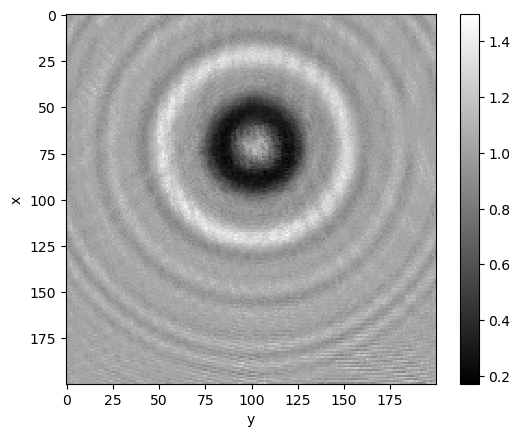

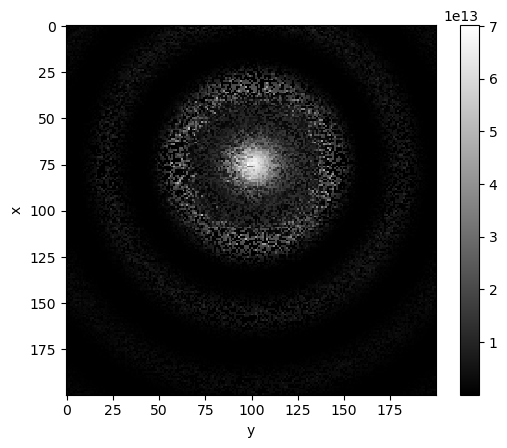

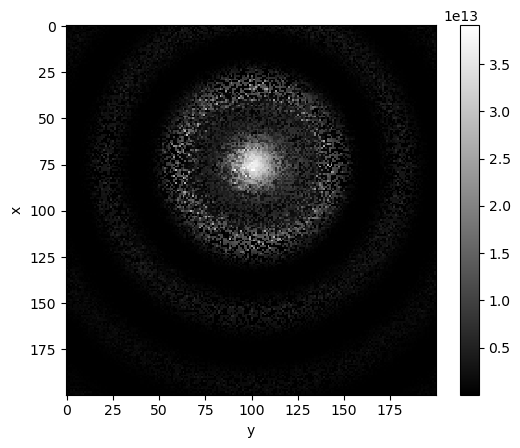

In [14]:
import holopy as hp
import numpy as np
from holopy.core.io import get_example_data_path, load_average
from holopy.core.process import bg_correct, subimage, normalize
from holopy.scattering import Sphere, Spheres, calc_holo
from holopy.inference import prior, ExactModel, CmaStrategy, EmceeStrategy
import time

# settings
pixel = 20/2.5/6

# load an image
imagepath = r'C:\Users\j05625pe\Documents\Work\Holograms\Resolv4k test\2022_09_29\Upper\Camera_1_C001H001S0001.png'
raw_holo = hp.load_image(imagepath, spacing = pixel, medium_index = 1.0,
                         illum_wavelen = 0.532, illum_polarization = (1,0))
bgpath = r'C:\Users\j05625pe\Documents\Work\Holograms\Resolv4k test\2022_09_29\Upper\background_4.png'
bg = load_average(bgpath, refimg = raw_holo)
data_holo = bg_correct(raw_holo, bg)
# hp.show(data_holo)

# process the image
data_holo = subimage(data_holo, [350,525], 200)  # center point and xy span
data_holo = normalize(data_holo)
hp.show(data_holo)

# Estimate center and z position using propagation
rough_center = [325*pixel, 525*pixel, 3800]
guess_sphere = Sphere(n=1.333, r=20.0, center=rough_center)
initial_guess = calc_holo(data_holo, guess_sphere)
# hp.show(initial_guess)

# Do the fitting
parameters_to_fit = ['x', 'y', 'z', 'r'] # We are not fitting the index refraction
t1 = time.perf_counter()
fit_result = hp.fit(data_holo, guess_sphere, parameters=parameters_to_fit)
fit_time = time.perf_counter() - t1

# Reading the result
best_fit_values = fit_result.parameters
initial_guess_values = fit_result.guess_parameters
best_fit_sphere = fit_result.scatterer
best_fit_hologram = fit_result.hologram
best_fit_lnprob = fit_result.max_lnprob
hp.show(best_fit_hologram)
print(f'Best fit values: {best_fit_values}')
print(f'Best fit sphere: {best_fit_sphere}')
print(f'Best fit lnprob: {best_fit_lnprob}')
print(f'Time of fitting: {fit_time:.1f} s.')